If you find any bugs in this ipython notebook, please post a question on Piazza or contact Fengze Liu (fliu23@jhu.edu).
If there's an error say "something is undefined", please run the cell that contains the definition or use "menu -> cell -> run all above"

Please download this ipynb file as well as the data folder as posted in Piazza (See also in https://nbviewer.jupyter.org/github/ccvl/VisualCortexCourse/tree/master/HW1/data/).
Original notebook by Weichao Qiu, modified by Donald Li, Chenxi Liu and Hongru Zhu.

# Initialization

In [2]:
# Import python library for this notebook
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function

# show figures inline
%matplotlib inline 

def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap=plt.gray(), **kwargs)

# Generate sinusoid stimuli

Sinusoid $ I(\mathbf{x}) = A \cos(\mathbf{\omega} \mathbf{x} + \rho) $

$ A $ is the amplitude, $ \rho $ is the phase, and $ \mathbf{\omega} $ is the frequency.

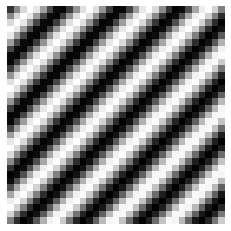

In [3]:
def genSinusoid(sz, A, omega, rho):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1)) # a BUG is fixed in this line

    stimuli = A * np.cos(omega[0] * x  + omega[1] * y + rho)
    return stimuli

theta = np.pi/4
omega = [np.cos(theta), np.sin(theta)]
sinusoidParam = {'A':1, 'omega':omega, 'rho':np.pi/2, 'sz':(32,32)}
myimshow(genSinusoid(**sinusoidParam)) 
# ** is a special syntax in python, which enables passing a key-value dictionary as parameter

# Generate gabor filter
A general type of Gabor filter[1] can be defined:  
$$ g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right) $$
[1] https://en.wikipedia.org/wiki/Gabor_filter  

Here we implement a type of Gabor filter which satisfies the neurophysiological constraints for simple cells:   
$$ \psi (x; \omega, \theta, K) = \left[\frac{\omega^2}{ 4 \pi K^2} \exp  \{-(\omega^2/8K^2)[4(x\cdot(cos\theta, sin\theta))^2 + (x \cdot ( -sin \theta, cos \theta))^2]\} \right] \times \left[ \exp \{ iwx \cdot (cos\theta, sin\theta) \} exp(K^2/2) \right] $$

1.5140274644582012e-05

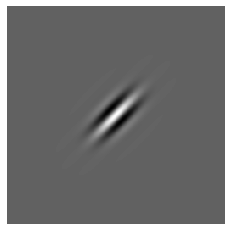

In [4]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor
        
g = genGabor((256,256), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
myimshow(g)
np.mean(g)

# Interactive: Gabor demo
If you evaluate the next cell in your computer, you can see an interactive demo like this.  
<img src="data/gabor/snapshot.png">

**Drag the slider to change parameters, and see the change of gabor filter.**

In [5]:
from IPython.html.widgets import interact, interactive, fixed
def demoGabor(theta, omega):
    myimshow(genGabor((128,128), omega, theta))
interact(demoGabor, theta=(0,np.pi,np.pi/4), omega=(0.1,1,0.1))

/home/fengze/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=1.5707963267948966, description='theta', max=3.141592653589793, step=0…

<function __main__.demoGabor(theta, omega)>

# Generate gabor filter bank

{'omega': 0.32000000000000006, 'theta': 2.356194490192345, 'sz': (128, 128)}


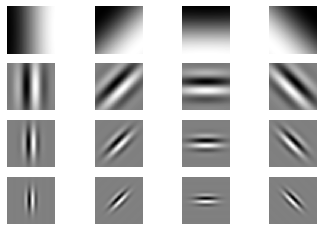

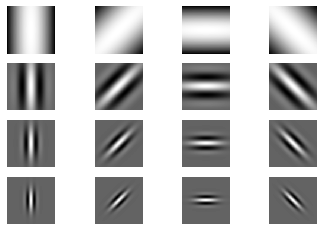

In [7]:
theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.02, 0.42, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(128, 128)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

plt.figure()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(sinFilterBank[i])

plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i])
print(gaborParam)

# Apply filter bank to zebra image

# Homework 4.1
Apply Gabor filters to the zebra image. Adjust the frequency and orientation of the Gabors to find the horizontal and vertical stripes. Plot the output. (3 points) Can you also find Gabors that respond to the legs? (3 points)

CPU times: user 5.67 s, sys: 51.6 ms, total: 5.73 s
Wall time: 4.81 s


<Figure size 432x288 with 0 Axes>

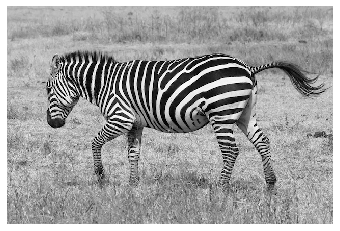

<Figure size 432x288 with 0 Axes>

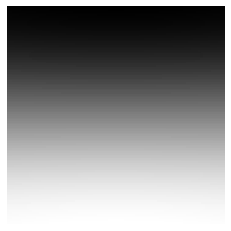

<Figure size 432x288 with 0 Axes>

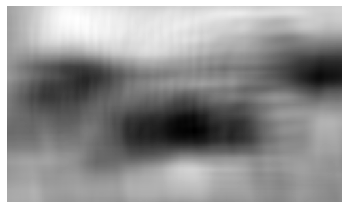

In [8]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
zebra = rgb2gray(plt.imread('data/gabor/Zebra_running_Ngorongoro.jpg'))
plt.figure(); myimshow(zebra)
sinGabor = sinFilterBank[2] 
plt.figure(); myimshow(sinGabor)
%time res = convolve2d(zebra, sinGabor, mode='valid') # Will take about one minute
plt.figure(); myimshow(res); # title('response') Book figure

"Zebra running Ngorongoro" by Muhammad Mahdi Karim (data/gabor/Zebra_running_Ngorongoro.jpg)

For examples of filters applied to texture processing see: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html

# Quadrature pair, simple/complex cell

# Homework4.2
Run the following Example, explain the results of the simple and complex cells when applying them to the stimuli. (4 points) Does the results match with your expectation?

Text(0.5, 1.0, 'Resp. of complex cell')

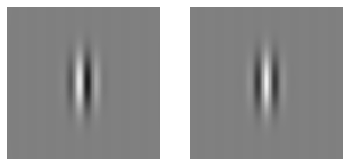

<Figure size 432x288 with 0 Axes>

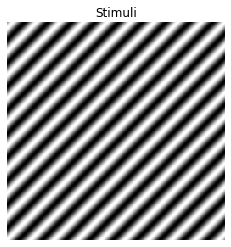

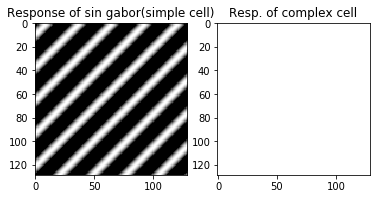

In [9]:
theta = np.pi
sinGabor = genGabor((129,129), 0.4, theta, np.sin)
cosGabor = genGabor((129,129), 0.4, theta, np.cos)
plt.figure(); 
plt.subplot(121); plt.axis('off'); plt.imshow(sinGabor, vmin=-0.2, vmax=0.2)
plt.subplot(122); plt.axis('off'); plt.imshow(cosGabor, vmin=-0.2, vmax=0.2)

theta = np.pi/4
sinusoid = genSinusoid((256,256), 1, (omega*np.sin(theta), omega*np.cos(theta)), 0)
plt.figure(); myimshow(sinusoid); plt.title('Stimuli')

response = convolve2d(sinusoid, sinGabor, mode='valid')
response2 = convolve2d(sinusoid, cosGabor, mode='valid')

plt.figure(); 
plt.subplot(121); plt.imshow(response, vmin=0); plt.title('Response of sin gabor(simple cell)')
plt.subplot(122); plt.imshow(response**2 + response2**2, vmin=0); plt.title('Resp. of complex cell')

# Homework 4.3: Find parameter of an unknown gabor filter
Find the tuning curve of an idealized neuron by measuring its response to different sinusoids. (3 points) 
The neuron is a Gabor function so you need to find its preferred orientation and phase. Use equations from _Slide: [SimpleCellsVisualCortex](https://cs.jhu.edu/~ayuille/JHUcourses/ProbabilisticModelsOfVisualCognition2017/Lecture3SimpleCells/SimpleCellsVisualCortex.pdf) - The Tuning of Gabor Filters _ if you want.

Strength of response: [[13.88121808]]


<Figure size 432x288 with 0 Axes>

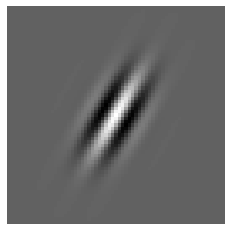

<Figure size 432x288 with 0 Axes>

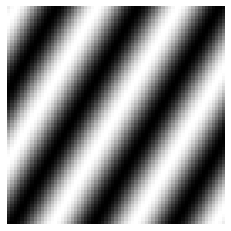

In [12]:
import pickle
# The parameter of this gabor(cell) is unknown
# Try to find its parameter:
unknownGabor = pickle.load(open('data/gabor/unknownGabor.data', 'rb'), encoding='latin1')
plt.figure(); myimshow(unknownGabor)

# You can use sinusoid as a stimuli
# For example:
rho = 0
omega = 0.3
theta = np.pi/6
sinusoid = genSinusoid(unknownGabor.shape, 1, (omega*np.cos(theta), omega*np.sin(theta)), rho)
plt.figure(); myimshow(sinusoid)
response = convolve2d(sinusoid, unknownGabor, mode='valid')
print('Strength of response:', response)

# Demo: Gaussian, Laplacian of Gaussian

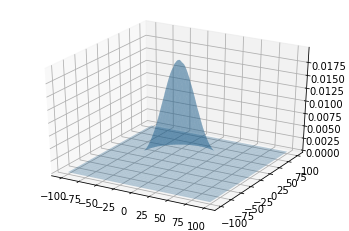

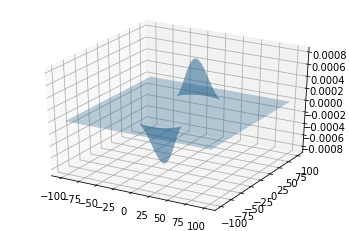

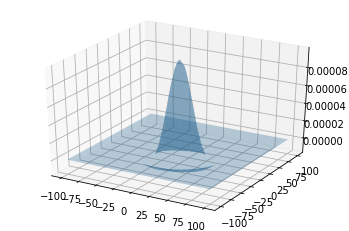

In [13]:
# Utility function to plot 3D surface
def surf(X, Y, Z, **kargs): 
    # Plot 3D data as surface, similar to surf(X,Y,Z) of http://www.mathworks.com/help/matlab/ref/surf.html
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, **kargs)
    
sigma = 20
from mpl_toolkits.mplot3d import Axes3D

[X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))
Z = 1/(np.sqrt(2.0 * np.pi) * sigma) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))

dx = np.roll(Z, 1, axis=1) - Z
dx2 = np.roll(dx, 1, axis=1) - dx

dy = np.roll(Z, 1, axis=0) - Z
dy2 = np.roll(dy, 1, axis=0) - dy

LoG = -(dx2+dy2)

surf(X, Y, Z, alpha=0.3)
# title('Gaussian')

surf(X, Y, dx + dy, alpha=0.3)
# title('First order derivative')

surf(X, Y, LoG, alpha=0.3)
# title('Second order derivative (Laplacian of Gaussian)')

# Homework 4.4  Find the parameter of Laplacian of Gaussian

Find the parameter $\sigma$ of a Laplacian of Gaussian filter by measuring its response to different sinusoids. (3 points)  
Use equation in _[LinearModelsSimpleCells](https://cs.jhu.edu/~ayuille/JHUcourses/ProbabilisticModelsOfVisualCognition2017/Lecture3SimpleCells/SimpleCellsRetina.pdf) - The Response of a Center-Surround Cell to sinusoids_ if you want.

Strength of response: [[0.06759985]]


<Figure size 432x288 with 0 Axes>

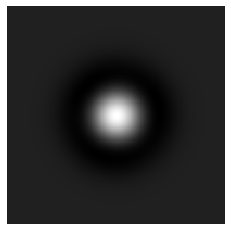

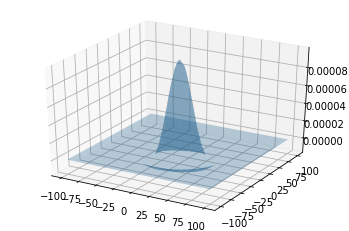

<Figure size 432x288 with 0 Axes>

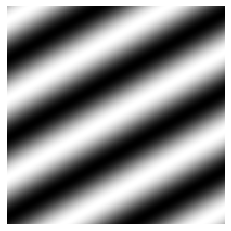

In [16]:
import pickle

unknownLoG = pickle.load(open('data/gabor/unknownLoG.data', 'rb'), encoding='latin1')
plt.figure(); myimshow(unknownLoG)
[X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))
surf(X, Y, unknownLoG, alpha=0.3)

# You can use sinusoid as a stimuli
# For example:
rho = 0
omega = 0.1
theta = np.pi/3
sinusoid = genSinusoid(unknownLoG.shape, 1, (omega*np.cos(theta), omega*np.sin(theta)), rho)
plt.figure(); myimshow(sinusoid)
response = convolve2d(sinusoid, unknownLoG, mode='valid')
print('Strength of response:', response)